<a href="https://colab.research.google.com/github/kesbeast23/ChatTest/blob/master/asr1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
! pip install datasets
! pip install huggingface_hub
!pip install pandas
!pip install transformers
!pip install matplotlib
!pip install librosa

In [2]:
!add-apt-repository -y ppa:jonathonf/ffmpeg-4 && apt update && apt install -y ffmpeg

Repository: 'deb https://ppa.launchpadcontent.net/jonathonf/ffmpeg-4/ubuntu/ jammy main'
Description:
Backport of FFmpeg 4 and associated libraries. Now includes AOM/AV1 support!

FDK AAC is not compatible with GPL and FFmpeg can't be redistributed with it included. Please don't ask for it to be added to this public PPA.

---

PPA supporters:

BigBlueButton (https://bigbluebutton.org)

---

Donate to FFMPEG: https://ffmpeg.org/donations.html
Donate to Debian: https://www.debian.org/donations
Donate to this PPA: https://ko-fi.com/jonathonf
More info: https://launchpad.net/~jonathonf/+archive/ubuntu/ffmpeg-4
Adding repository.
Adding deb entry to /etc/apt/sources.list.d/jonathonf-ubuntu-ffmpeg-4-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/jonathonf-ubuntu-ffmpeg-4-jammy.list
Adding key to /etc/apt/trusted.gpg.d/jonathonf-ubuntu-ffmpeg-4.gpg with fingerprint 4AB0F789CBA31744CC7DA76A8CF63AD3F06FC659
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubun

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import librosa
from datasets import load_dataset


In [6]:
from huggingface_hub import login
login()

In [7]:
# Load the TORGO dataset
dataset = load_dataset("jmaczan/TORGO")

Resolving data files:   0%|          | 0/2755 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/2754 [00:00<?, ? examples/s]

In [9]:
 #Convert the dataset to a pandas DataFrame for easier analysis
df = pd.DataFrame(dataset['train'])

In [10]:
# Display the first few rows of the DataFrame
print("First few rows of the dataset:")
print(df.head())

First few rows of the dataset:
                                               audio  \
0  {'path': '/root/.cache/huggingface/datasets/do...   
1  {'path': '/root/.cache/huggingface/datasets/do...   
2  {'path': '/root/.cache/huggingface/datasets/do...   
3  {'path': '/root/.cache/huggingface/datasets/do...   
4  {'path': '/root/.cache/huggingface/datasets/do...   

                                       transcription  
0                                              stick  
1                                              tear   
2  except in the winter when the ooze or snow or ...  
3                                                pat  
4                                                 up  


In [13]:
 #Analysis of the dataset

# Calculate the proportion of single words and sentences
df['word_count'] = df['transcription'].apply(lambda x: len(x.split()))

# Proportion of single words
single_word_count = len(df[df['word_count'] == 1])
total_count = len(df)
single_word_proportion = single_word_count / total_count

# Proportion of sentences
sentence_count = total_count - single_word_count
sentence_proportion = sentence_count / total_count

print(f"Total entries: {total_count}")
print(f"Single words: {single_word_count} ({single_word_proportion * 100:.2f}%)")
print(f"Sentences: {sentence_count} ({sentence_proportion * 100:.2f}%)")


Total entries: 2754
Single words: 2116 (76.83%)
Sentences: 638 (23.17%)


In [14]:
# Display some examples of single words and sentences
print("Examples of single words:")
print(df[df['word_count'] == 1].head())

print("Examples of sentences:")
print(df[df['word_count'] > 1].head())

Examples of single words:
                                               audio transcription  word_count
0  {'path': '/root/.cache/huggingface/datasets/do...         stick           1
1  {'path': '/root/.cache/huggingface/datasets/do...         tear            1
3  {'path': '/root/.cache/huggingface/datasets/do...           pat           1
4  {'path': '/root/.cache/huggingface/datasets/do...            up           1
5  {'path': '/root/.cache/huggingface/datasets/do...          meat           1
Examples of sentences:
                                                audio  \
2   {'path': '/root/.cache/huggingface/datasets/do...   
8   {'path': '/root/.cache/huggingface/datasets/do...   
14  {'path': '/root/.cache/huggingface/datasets/do...   
16  {'path': '/root/.cache/huggingface/datasets/do...   
20  {'path': '/root/.cache/huggingface/datasets/do...   

                                        transcription  word_count  
2   except in the winter when the ooze or snow or ...          12 

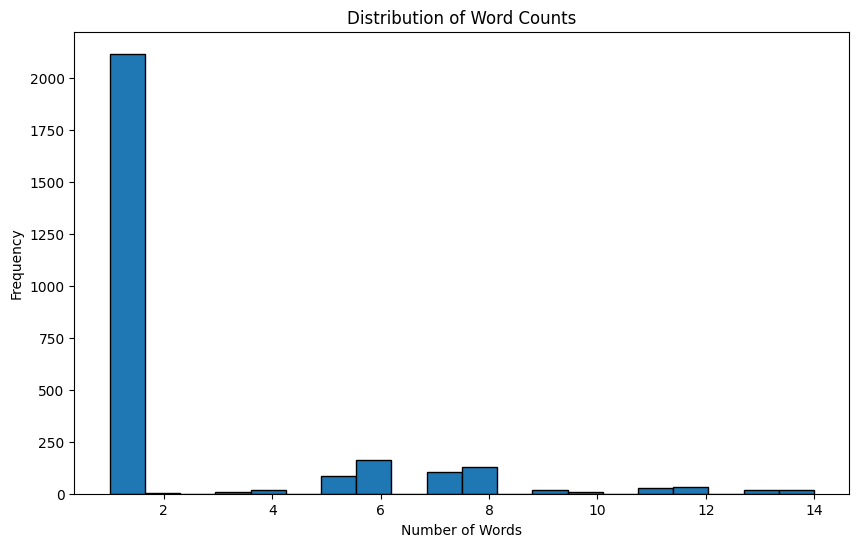

In [15]:
# Visualizations

# Histogram of word counts
plt.figure(figsize=(10, 6))
plt.hist(df['word_count'], bins=20, edgecolor='black')
plt.title('Distribution of Word Counts')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


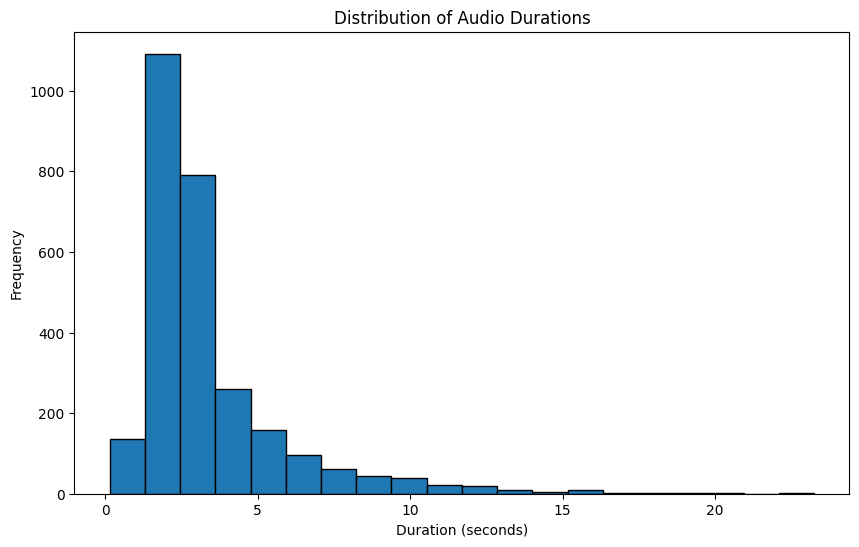

In [16]:
# Calculate and visualize audio durations
def get_audio_duration(audio):
    y, sr = librosa.load(audio['path'], sr=None)
    return librosa.get_duration(y=y, sr=sr)

df['audio_duration'] = df['audio'].apply(get_audio_duration)

# Histogram of audio durations
plt.figure(figsize=(10, 6))
plt.hist(df['audio_duration'], bins=20, edgecolor='black')
plt.title('Distribution of Audio Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

In [17]:
# Prepare dataset for Whisper ASR models
from datasets import Dataset
torgo_dataset = Dataset.from_pandas(df)

 #Display the dataset ready for Whisper ASR evaluation
print("Dataset ready for Whisper ASR evaluation:")
print(torgo_dataset)

Dataset ready for Whisper ASR evaluation:
Dataset({
    features: ['audio', 'transcription', 'word_count', 'audio_duration'],
    num_rows: 2754
})


In [24]:
# Download and load a pre-trained Whisper ASR model for evaluation
from transformers import pipeline

# Replace with the appropriate Whisper model
asr_model = pipeline("automatic-speech-recognition", model="openai/whisper-base",generate_kwargs={"task": "transcribe","language":"<|en|>"})


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [28]:
# Example: Transcribing a sample audio from the dataset
sample_audio = df.iloc[0]['audio']
transcription = asr_model(sample_audio['path'])


/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


Sample transcription:
{'text': ' Nick!'}


In [33]:
from IPython.display import Audio, display
# Example: Transcribing a sample audio from the dataset
sample_audio = df.iloc[0]['audio']
transcription = asr_model(sample_audio['path'])

print("Sample transcription:")
print(transcription)

# Play the sample audio
print("Playing sample audio:")
display(Audio(sample_audio['path'], autoplay=True))


/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


Sample transcription:
{'text': ' Nick!'}
Playing sample audio:


In [34]:
# Evaluate ASR model on the dataset
def evaluate_asr_model(df, model):
    references = []
    predictions = []

    for index, row in df.iterrows():
        transcription = model(row['audio']['path'])['text']
        references.append(row['transcription'])
        predictions.append(transcription)

    return references, predictions

references, predictions = evaluate_asr_model(df, asr_model)


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/generation_whispe

In [35]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 47.6 MB/s eta 0:00:00


In [36]:
# Calculate Word Error Rate (WER)
from jiwer import wer

error_rate = wer(references, predictions)
print(f"Word Error Rate (WER): {error_rate:.2f}")


Word Error Rate (WER): 1.35


In [ ]:
# Visualize the WER distribution
wer_distribution = [wer([ref], [pred]) for ref, pred in zip(references, predictions)]

plt.figure(figsize=(10, 6))
plt.hist(wer_distribution, bins=20, edgecolor='black')
plt.title('Distribution of Word Error Rates')
plt.xlabel('WER')
plt.ylabel('Frequency')
plt.show()